In [49]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 300
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.facecolor'] = 'white'

In [50]:
# Define the  physical constants for the pendulum experiment

g=9.81  # m/s^2
L=0.125 # distance from pendulum's centre of mass to pivot in m
a=0.016 # radius of pulley in m
m=0.32  # mass of pendulum in kg
M=0.7  # mass of carriage in kg
I=8e-5  # moment of inertia on motor shaft in kg m^2
km = 0.08  # torque motor constant in Nm/A
ka = -0.50 # amplifier constant in A/V

gamma =  M/m + I/(m*np.power(a,2))

#scale factors to get physical units metres radians and seconds.
#in the crane/down position
# [x xdot Ltheta Lthetadot]=[CP CV PP PV]*Sc where,
Sc=np.diag([-1/12.5, -1/2.23, L/3.18, L/0.64])

# in the inverted position
# [x xdot Lphi Lphidot]=[CP CV PP PV]*Sp where,
Sp=np.diag([-1/12.5, -1/2.23, L/3.18, -L/0.64])

#controller amplifier gains on each measurement
opamp_c = np.diag([-20,-30, 20, -10]) # for crane controller
opamp_p = np.diag([10,20,30,-20]) # for inverted pendulum controller

#maximum torque from the motor in Nm
Tmax=0.4

# squares of the natural frequencies
om12=g/L 
om02=om12*(1+1/gamma)

#linearized crane  model

Ac=np.array([[0, 1, 0, 0,], [0, 0, om12-om02, 0], [0, 0, 0, 1], [0, 0, -om02, 0]])
Cc=-(ka*km/(m*a*gamma))*np.linalg.solve(Sc,opamp_c)
B=np.array([[0],[1],[0],[1]])

#linearized inverted pendulum model
Ap=np.array([[0, 1, 0, 0], [0, 0, om02-om12, 0], [0, 0, 0, 1], [0, 0, om02, 0]])
Cp=-(ka*km/(m*a*gamma))*np.linalg.solve(Sp,opamp_p)

# Sampling period 
h=0.0025 #sampling period
h_sim=0.002 #simulation step size


In [51]:
# Define helper functions

def solver_crane(x0,tsim,tdem,xdem,p):
  x = np.copy(x0)
  x_sim = x.reshape(1,4)
  T_sim = []
  if x0[2]>0.05:
      stopped=0
  else:
      stopped =1
    
  def next_state_crane(x):
    theta = x[2]/L
    sinth = np.sin(theta)
    costh = np.cos(theta)
    newx = np.empty(4) 
    nonlocal stopped
    if stopped==1 and (np.abs(T/a - m*g*sinth*costh - m/L*sinth*x[3]**2)< Fstatic):
        newx[0] = x[0]
        newx[1] = 0.0
        newx[2] = x[2]+ h_sim*x[3]+0.5*h_sim**2*(-g*sinth)
        sinth1 = np.sin(newx[2]/L)
        costh1 = np.cos(newx[2]/L)
        newx[3] = x[3] -h_sim*g*(sinth+sinth1)*0.5
    else:
         stopped=0
         x24dot =np.linalg.solve(np.array([[1+gamma,-costh],[-costh,1]]),np.array([-sinth/L*x[3]**2 + T/(m*a)-(F/m)*np.sign(x[1]),-g*sinth]))    
         newx[[0,2]]=x[[0,2]]+h_sim*x[[1,3]]+0.5*(h_sim**2)*x24dot

         sinth1 = np.sin(newx[2]/L)
         costh1 = np.cos(newx[2]/L)
         x24dot1 = np.linalg.solve(np.array([[1+gamma,-costh1],[-costh1,1]]),np.array([-sinth1/L*x[3]**2 + T/(m*a)-(F/m)*np.sign(x[1]),-g*sinth1]))    
         newx[[1,3]]=x[[1,3]]+h_sim*0.5*(x24dot+x24dot1)
         if((x[1]!=0.0) & (x[1]*newx[1]<=0.0)):
             stopped= 1
    return newx

  for t in tsim:
      xd = np.interp(t,tdem,xdem)
      T= (ka*km*P@ opamp_c@ np.linalg.solve(Sc,(x-np.array([xd,0,0,0]))))[0]
      if np.abs(T)>Tmax:
          T= Tmax*np.sign(T)
      T_sim.append(T.item())
      x = next_state_crane(x)
      x_sim = np.vstack((x_sim,np.transpose(x)))
  return x_sim
# Define helper functions

def solver_pendulum(x0,tsim,tdem,xdem,p):
  x = np.copy(x0)
  x_sim = x.reshape(1,4)
  T_sim = []
  if x0[2]>0.05:
      stopped=0
  else:
      stopped =1

  def next_state_pendulum(x):
    phi = x[2]/L
    sinphi = np.sin(phi)
    cosphi = np.cos(phi)
    newx = np.empty(4) 
    nonlocal stopped
    if stopped==1 and (np.abs(T/a + m*g*sinphi*cosphi - m/L*sinphi*newx[3]**2)< Fstatic): #x[3]
        newx[0] = x[0]
        newx[1] = 0.0
        newx[2] = x[2]+ h_sim*x[3]+0.5*h_sim**2*(g*sinphi)
        sinphi1 = np.sin(newx[2]/L)
        cosphi1 = np.cos(newx[2]/L)
        newx[3] = x[3] +h_sim*g*(sinphi+sinphi1)*0.5
    else:
         stopped=0
         x24dot =np.linalg.solve(np.array([[1+gamma,-cosphi],[cosphi,-1]]),np.array([-sinphi/L*x[3]**2 + T/(m*a)-(F/m)*np.sign(x[1]),-g*sinphi]))    
         newx[[0,2]]=x[[0,2]]+h_sim*x[[1,3]]+0.5*(h_sim**2)*x24dot

         sinphi1 = np.sin(newx[2]/L)
         cosphi1 = np.cos(newx[2]/L)
         x24dot1 = np.linalg.solve(np.array([[1+gamma,-cosphi1],[cosphi1,-1]]),np.array([-sinphi1/L*x[3]**2 + T/(m*a)-(F/m)*np.sign(x[1]),-g*sinphi1]))    
         newx[[1,3]]=x[[1,3]]+h_sim*0.5*(x24dot+x24dot1)
         if((x[1]!=0.0) & (x[1]*newx[1]<=0.0)):
             stopped= 1
    return newx

  for t in tsim:
      xd = np.interp(t,tdem,xdem)
      T= (ka*km*p@ opamp_p@ np.linalg.solve(Sp,(x-np.array([xd,0,0,0]))))[0]
      if np.abs(T)>Tmax:
          T= Tmax*np.sign(T)
      T_sim.append(T.item())
      x = next_state_pendulum(x)
      x_sim = np.vstack((x_sim,np.transpose(x)))
  return x_sim

def loadlogdata(n,ScaleF):
  folder = "lqr_data/"

  if n> 9:
    filename = folder + 'Plot 0' + str(n) + '.csv'
  else:
    filename = folder + 'Plot 00' + str(n)+ '.csv'

  LoadedDataCSV = np.genfromtxt(filename,delimiter=',',skip_header=16)
  # this seems to be sufficient if the offset for the header is always the same
  #print(LoadedDataCSV)
  #LoadedDataCSV = np.delete(LoadedDataCSV,-1,axis=1)
  #print(LoadedDataCSV)
  DataOfInterestCSV = np.array(LoadedDataCSV[:,[2,3,4,5,1]])
  # we now need to swap data so to place it in the following order
  # t CP CV PP PV CD
  # from an orginal order of: 
  # t CD CP CV PP PV
  logdataCSV = DataOfInterestCSV*20/4095-10
  logdataCSV[:,[1,2,3]] = -logdataCSV[:,[1,2,3]]
  xdata=np.concatenate([logdataCSV[:,0:4]@ScaleF, logdataCSV[:,-1:]*ScaleF[0,0]], axis=1)
  ###  
  xdem = xdata[:,-1]
  endtime=LoadedDataCSV[-1,0]
  t = np.linspace(0,endtime,xdata.shape[0])

  return xdata, xdem, t
 
def plot_function_crane(t0,tf,t,xdata,tsim,x_sim,p):
  ind = (t>=t0) & (t<=tf)
  plt.figure()
  plt.suptitle("Crane position with p = %s"%p, fontsize=15)

  plt.subplot(411)
  plt.plot(t[ind],xdata[ind,0], color='blue') #data
  plt.plot(tsim,x_sim[:-1,0], color='red',linestyle='--') #simulation
  plt.plot(t[ind],xdata[ind,-1], linestyle =':', color='green') # Demand
  plt.legend(['Measured','Simulated','Demand']);
  plt.ylabel("x[m]")
  plt.grid()

  plt.subplot(412)
  plt.plot(t[ind],xdata[ind,1], color='blue') #data
  plt.plot(tsim,x_sim[:-1,1], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']); 
  plt.ylabel("v[m/s]")
  plt.grid()

  plt.subplot(413)
  plt.plot(t[ind],xdata[ind,2], color='blue') #data
  plt.plot(tsim,x_sim[:-1,2], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']);
  plt.ylabel("L$\Theta$[m]")
  plt.grid()

  plt.subplot(414)
  plt.plot(t[ind],xdata[ind,3], color='blue') #data
  plt.plot(tsim,x_sim[:-1,3], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']);
  plt.ylabel("L$\omega$[m/s]")
  plt.grid()

  plt.xlabel("time [s]")

def plot_function_pendulum(t0,tf,t,xdata,tsim,x_sim,p):
  ind = (t>=t0) & (t<=tf)
  plt.figure()
  plt.suptitle("Pendulum position with p = %s"%p, fontsize=15)

  plt.subplot(411)
  plt.plot(t[ind],xdata[ind,0], color='blue') #data
  plt.plot(tsim,x_sim[:-1,0], color='red',linestyle='--') #simulation
  plt.plot(t[ind],xdata[ind,-1], linestyle =':', color='green') # Demand
  plt.legend(['Measured','Simulated','Demand']);
  plt.ylabel("x[m]")
  plt.grid()

  plt.subplot(412)
  plt.plot(t[ind],xdata[ind,1], color='blue') #data
  plt.plot(tsim,x_sim[:-1,1], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']); 
  plt.ylabel("v[m/s]")
  plt.grid()

  plt.subplot(413)
  plt.plot(t[ind],xdata[ind,2], color='blue') #data
  plt.plot(tsim,x_sim[:-1,2], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']);
  plt.ylabel("L$\Theta$[m]")
  plt.grid()

  plt.subplot(414)
  plt.plot(t[ind],xdata[ind,3], color='blue') #data
  plt.plot(tsim,x_sim[:-1,3], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']);
  plt.ylabel("L$\omega$[m/s]")
  plt.grid()

  plt.xlabel("time [s]")

In [52]:
F = 3.0
Fstatic = 2.4

In [53]:

def eval_cost_data(x0, xdata, tdata, P, Q, R):

    if xdata.shape[0] == tdata.shape[0] - 1:
        xdata = np.vstack((x0, xdata))

    r = xdata[:,-1]
    u = r - np.einsum('ij,jkl->il',
                      (P @ Cc).reshape(1, 4),
                      xdata[:,:4].reshape(4, 1, -1)
                      )
    # integrate input and output cost
    cost = 0
    cost += Q[0,0] * np.trapz(
        (xdata[:,0] - xdata[:,-1]) ** 2, tdata
    ) # carriage position
    cost += Q[1,1] * np.trapz(
        xdata[:,1] ** 2, tdata
    ) # carriage velocity
    cost += Q[2,2] * np.trapz(
        xdata[:,2] ** 2, tdata
    ) # pendulum angle
    cost += Q[3,3] * np.trapz(
        xdata[:,3] ** 2, tdata
    ) # pendulum angular velocity

    # input cost is more complicated as we need to calculate input from states
    # u = r - Kx 
    
    cost += np.trapz(
        R * u ** 2, tdata
    ) # input cost

    return cost
    


In [54]:
import control as ctrl

sys_p = ctrl.ss(Ap,B,Cp,0)

max_x = 0.4 # meters
max_theta = 60 * np.pi / 180 # degrees
max_xdot = 100 # m/s
max_thetadot = 100 # rad/s

max_input_power = 900 # W
max_torque = max_input_power / max_thetadot # Nm

max_u = max_torque / (a * gamma)

Q = np.diag([
    1/max_x**2, 
    1/max_xdot**2, 
    1/(L*max_theta)**2, 
    1/(L*max_thetadot)**2])

R = np.array([1/max_u**2])

print(R)

Kp, Sp, Ep = ctrl.lqr(sys_p, Q, R)

Pp = Kp @ np.linalg.inv(Cp)

if np.any(np.abs(Pp) > 1):
    Pp /= np.max(np.abs(Pp))
    print("warning : gains are scaled")

Pp = np.round(Pp, 2)

print("Gains : ")
print(Pp)

print("Poles : ")
print(np.linalg.eigvals(Ap - B @ Pp @ Cp))



[3.1640625e-05]
Gains : 
[[0.97 1.   0.88 0.61]]
Poles : 
[-17.90793047+24.7541394j  -17.90793047-24.7541394j
  -4.14639051 +2.82450026j  -4.14639051 -2.82450026j]


[1.99232399]


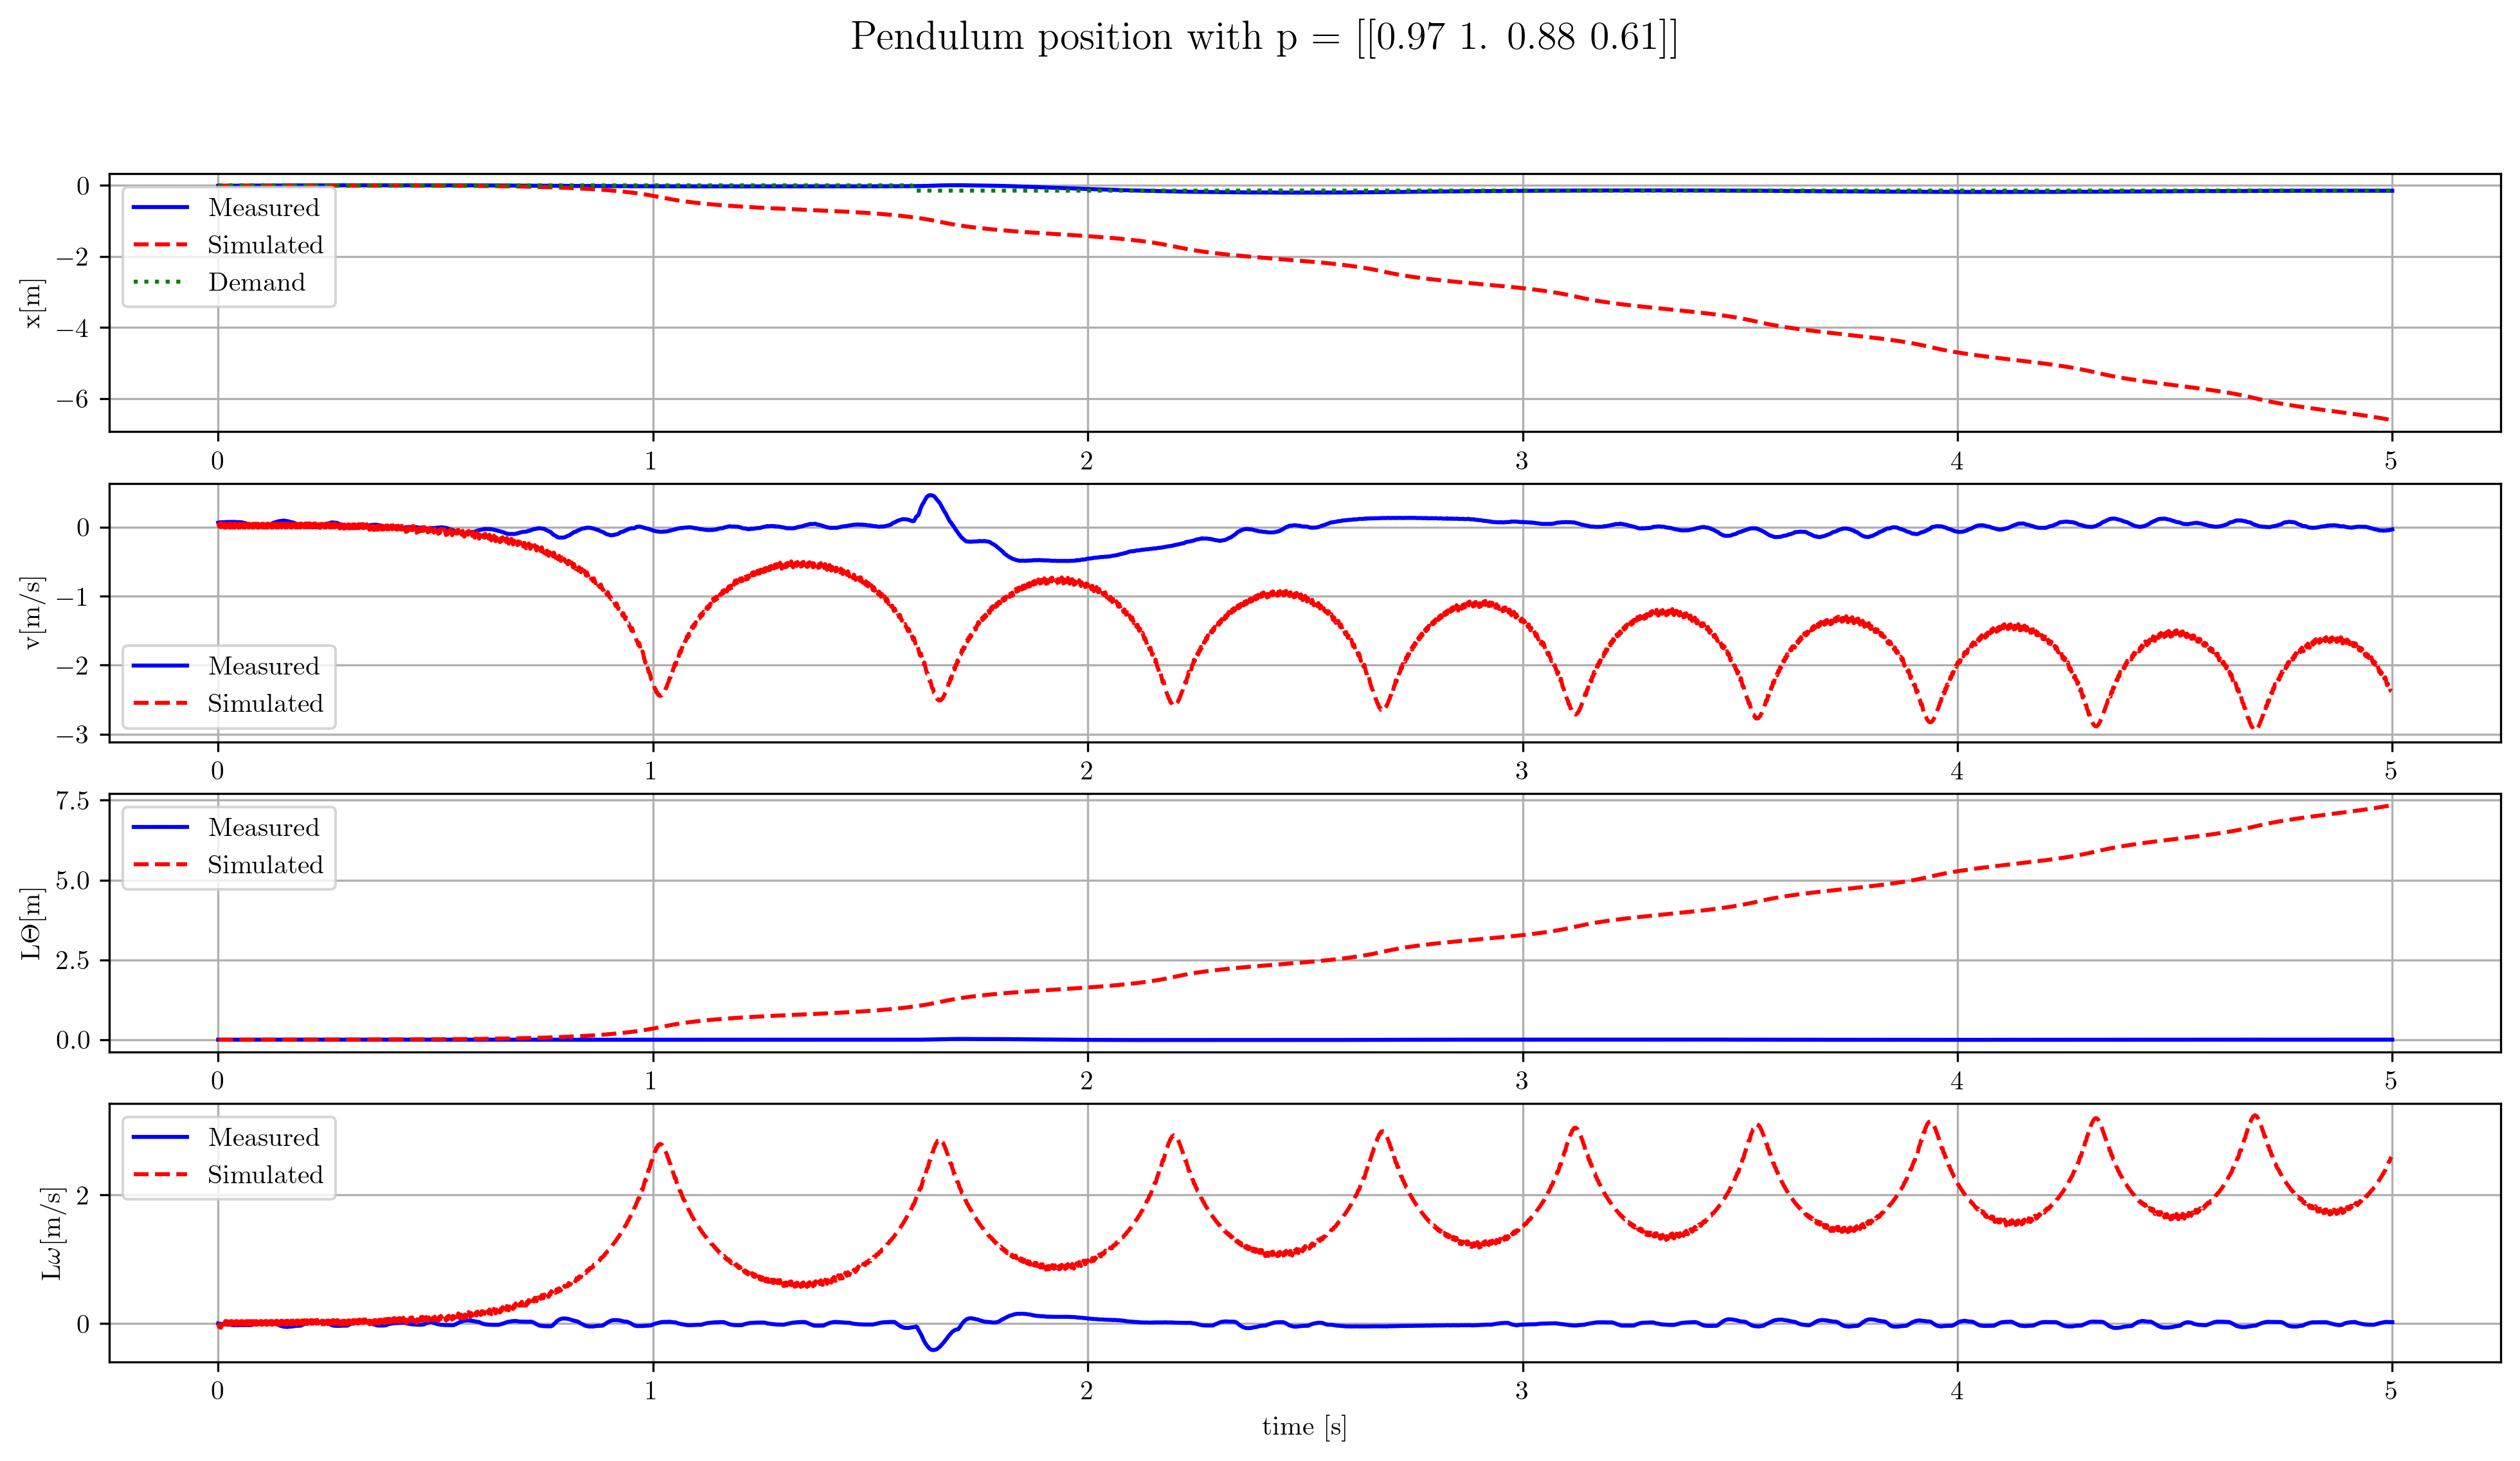

In [56]:
############################## LOAD DATA  #######################################

xdata, xdem, tdata = loadlogdata(32,Sc)

tsim = np.arange(0,5,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(0)

x_sim = solver_pendulum(x0,tsim,tdata,xdem,Pp)

plot_function_pendulum(0,5,tdata,xdata,tsim,x_sim,Pp)

print(eval_cost_data(x0, xdata, tdata, Pp, Q, R))
